---
title: "Lecture 7: Fitting to data, Normal equations, Space of linear systems"
author: "Jamie Haddock"
format: 
    revealjs:
        output-file: Lecture7_slides
        slide-number: true
        chalkboard: 
            buttons: false
        preview-links: auto
        logo: figs/hmc.png
        css: input/slides.css
        incremental: true
        smaller: true
        code-fold: true
    html: 
        code-fold: true
    pdf:
        documentclass: article
        toc: true
        number-sections: true
        geometry:
          - top=1in
          - left=1in
          - bottom=1in
          - right=1in
format-links: false
jupyter: julia-1.9
filters: 
  - input/remove-pause.lua
execute:
  echo: true
  eval: true
---

# Fitting functions to data

Previously, we saw how interpolating data with a polynomial can be solved by a linear system of equations.  However, interpolation is often not an appropriate model for learning a functional relationship from data!

## Example: worldwide temperature anomaly

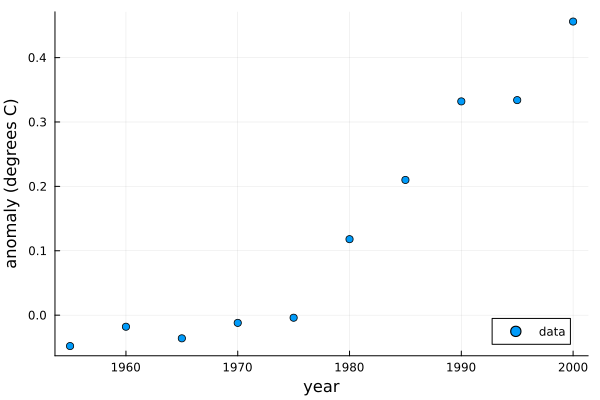

In [16]:
using Plots

year = 1955:5:2000
temp = [ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040, 0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ]

scatter(year, temp, label="data", xlabel="year", ylabel="anomaly (degrees C)", leg=:bottomright)

---

In [17]:
t = @. (year-1950)/10
n = length(t)
V = [ t[i]^j for i in 1:n, j in 0:n-1 ]
c = V\temp

10-element Vector{Float64}:
  -14.114000001832462
   76.36173810552113
 -165.45597224550528
  191.96056669514388
 -133.27347224319684
   58.015577787494486
  -15.962888891734785
    2.6948063497166928
   -0.2546666667177082
    0.010311111113288083

---

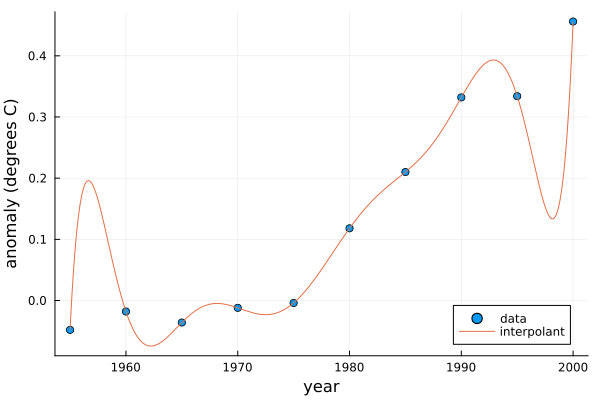

In [18]:
using Polynomials

p = Polynomial(c)
f = yr -> p((yr-1950)/10)
plot!(f,1955,2000,label="interpolant")

. . .

For this application, this functional relationship is far too complex!  This is known as *overfitting*.

---

We can get better results (in this case and many others) by relaxing the interpolant requirement -- this is equivalent to lowering the degree of the fitting polynomial.

. . .

Let $(t_i, y_i)$ for $i = 1, \cdots, m$ be the given points, and let the polynomial be given by $$y \approx f(t) = c_1 + c_2 t + \cdots + c_{n-1} t^{n-2} + c_n t^{n-1},$$ with $n < m$.

. . .

We seek an approximation such that $$\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \vdots \\ y_m \end{bmatrix} \approx \begin{bmatrix} f(t_1) \\ f(t_2) \\ f(t_3) \\ \vdots \\ f(t_m) \end{bmatrix} = \begin{bmatrix} 1 & t_1 & \cdots & t_1^{n-1} \\ 1 & t_2 & \cdots & t_2^{n-1} \\ 1 & t_3 & \cdots & t_3^{n-1} \\ \vdots & \vdots & \cdots & \vdots \\ 1 & t_m & \cdots & t_m^{n-1} \end{bmatrix} \begin{bmatrix} c_1 \\ c_2 \\ \vdots \\ c_n \end{bmatrix} = \mathbf{V}\mathbf{c}.$$

. . .

Note that this matrix has the same structure as the Vandermonde matrix but is $m \times n$ with $m \ge n$, and the system is **overdetermined** -- it has more conditions than variables.  

---

Overdetermined systems are often **inconsistent**, like this one, and have no exact solution (although it is not impossible for such a system to be consistent).  The best approximation of such a system is also given by the `\` operator in Julia.

In [19]:
V = [ t.^0 t ]   # Vandermonde-ish matrix
@show size(V)
c = V\temp
p = Polynomial(c)

size(V) = (10, 2)


Polynomial(-0.18773333333333356 + 0.11670303030303034*x)

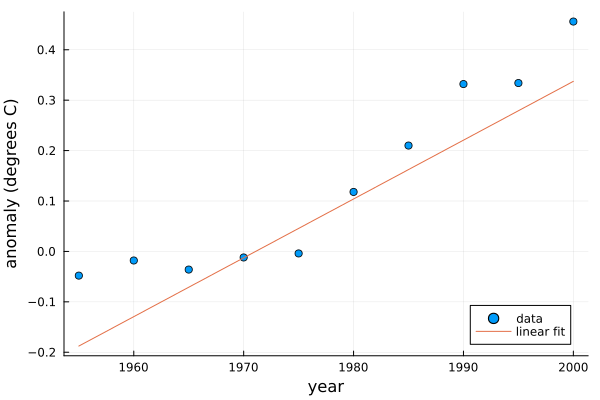

In [20]:
f = yr -> p((yr-1955)/10)
scatter(year,temp,label="data",xlabel="year",ylabel="anomaly (degrees C)",leg=:bottomright)
plot!(f,1955,2000,label="linear fit")

---

A cubic polynomial fits the data even better.

size(V) = (10, 4)


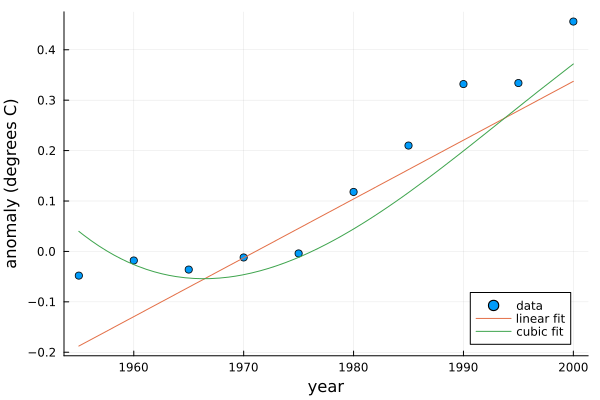

In [21]:
V = [ t[i]^j for i in 1:length(t), j in 0:3 ]
@show size(V)
p = Polynomial( V\temp )
plot!(f,1955,2000,label="cubic fit")

# Least-squares formulation

This problem here is to fit $y_i \approx f(t_i)$ where $f(t) = c_1 + c_2 t^1 + \cdots + c_n t^{n-1}$.  This is a special case of the more general case with generic basis functions $f(t) = c_1 f_1(t) + c_2 f_2(t) + \cdots + c_n f_n(t)$.

## Least-squares formulation

In either case, the  fitting problem solved here is $$\min R(c_1, \cdots, c_n) = \sum_{i=1}^m [y_i - f(t_i)]^2 =: \mathbf{r}^\top \mathbf{r} = \|\mathbf{r}\|^2,$$

. . .

where $$\mathbf{r} = \begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_{m-1} \\ y_m \end{bmatrix} - \begin{bmatrix} f_1(t_1) & f_2(t_1) & \cdots & f_n(t_1) \\ f_1(t_2) & f_2(t_2) & \cdots & f_n(t_2) \\ \vdots & \vdots & \cdots & \vdots \\ f_1(t_{m-1}) & f_2(t_{m-1}) & \cdots & f_n(t_{m-1}) \\ f_1(t_m) & f_2(t_m) & \cdots & f_n(t_m) \end{bmatrix} \begin{bmatrix} c_1 \\ c_2 \\ \vdots \\ c_n \end{bmatrix}.$$  

---

::: {.callout-note icon=false}
## Definition: Linear least-squares problem
Given $\mathbf{A} \in \mathbb{R}^{m \times n}$ and $\mathbf{b} \in \mathbb{R}^m$, with $m > n$, find $$\text{argmin}_{\mathbf{x} \in \mathbb{R}^n} \|\mathbf{b} - \mathbf{A}\mathbf{x}\|_2^2.$$
:::

[Here, $\text{argmin}$ is short for *argument minimizing* -- this asks one to find the variable, $\mathbf{x} \in \mathbb{R}^n$, that minimizes the objective funcion.]{.content-hidden when-format='revealjs' when-format='pptx'} 

. . .

Note that if we find a solution to the linear system, then $\mathbf{r} = \mathbf{0}$.

## The normal equations

::: {.callout-warning icon=false}
## Theorem: 

If $\mathbf{x}$ satisfies $\mathbf{A}^\top (\mathbf{A}\mathbf{x} - \mathbf{b}) = \mathbf{0}$ then $\mathbf{x}$ solves the linear least-squares problem -- $\mathbf{x}$ minimizes $\|\mathbf{x} - \mathbf{A}\mathbf{x}\|_2$.
:::

<details><summary>Proof:</summary> 
We'll show that any other vector $\mathbf{x}' = \mathbf{x} + \mathbf{y}$  has objective function value at least as large as the objective function at $\mathbf{x}$.  Note that 
\begin{align*}
\|\mathbf{A} \mathbf{x}' - \mathbf{b}\|_2^2 &= \left[(\mathbf{A}\mathbf{x} - \mathbf{b}) + (\mathbf{A}\mathbf{y})\right]^\top \left[(\mathbf{A}\mathbf{x} - \mathbf{b}) + (\mathbf{A}\mathbf{y})\right]
\\&= \|\mathbf{A}\mathbf{x} - \mathbf{b}\|_2^2 + 2 \mathbf{y}^\top \mathbf{A}^\top (\mathbf{A}\mathbf{x} - \mathbf{b}) + \|\mathbf{A}\mathbf{y}\|_2^2
\\&= \|\mathbf{A}\mathbf{x} - \mathbf{b}\|_2^2 + \|\mathbf{A}\mathbf{y}\|_2^2
\\&\ge \|\mathbf{A}\mathbf{x} - \mathbf{b}\|_2^2.
\end{align*}
</details>

---

::: {.callout-note icon=false}
## Definition: Normal equations
Given $\mathbf{A} \in \mathbb{R}^{m \times n}$ and $\mathbf{b} \in \mathbb{R}^m$, the **normal equations** for the linear least-squares problem $\text{argmin} \|\mathbf{b} - \mathbf{A}\mathbf{x}\|$ are $\mathbf{A}^\top (\mathbf{A}\mathbf{x} - \mathbf{b}) = \mathbf{0}$, or equivalently, $$\mathbf{A}^\top \mathbf{A} \mathbf{x} = \mathbf{A}^\top \mathbf{b}.$$
:::

. . .

![Least-squares geometry](figs/least_squares.png){height=400}

## Pseudoinverse and definiteness

The normal equations show us that we can solve the least-squares problem by solving this system of linear equations.

::: {.callout-note icon=false}
## Definition: Pseudoinverse
If $\mathbf{A} \in \mathbb{R}^{m \times n}$ with $m > n$, its **pseudoinverse** is the $n \times m$ matrix $$\mathbf{A}^\dagger = (\mathbf{A}^\top \mathbf{A})^{-1} \mathbf{A}^\top.$$
:::

. . .

The overdetermined least-squares problem has solution $\mathbf{x} = \mathbf{A}^\dagger \mathbf{b}$. [In Julia, the backslash operator `\` is mathematically equivalent to left multiplication by the inverse matrix in the square case and by the pseudoinverse in the overdetermined rectangular case.]{.content-hidden when-format='revealjs' when-format='pptx'} 

::: {.callout-warning icon=false}
## Theorem: 
For any real $m \times n$ matrix $\mathbf{A}$ with $m \ge n$, the following are true:

1. $\mathbf{A}^\top \mathbf{A}$ is symmetric.
2. $\mathbf{A}^\top \mathbf{A}$ is singular if and only if the columns of $\mathbf{A}$ are linearly dependent; that is, if the rank of $\mathbf{A}$ is less than $n$.
3. if $\mathbf{A}^\top \mathbf{A}$ is nonsingular, then it is positive definite.
:::

## Implementation

The algorithm for solving least-squares by the normal equations is:

1. Compute $\mathbf{N} = \mathbf{A}^\top \mathbf{A}$.
2. Compute $\mathbf{z} = \mathbf{A}^\top \mathbf{b}$.
3. Solve the $n \times n$ linear system $\mathbf{N}\mathbf{x} = \mathbf{z}$ for $\mathbf{x}$.

In [22]:
"""
    lsnormal(A,b)
Solve a linear least-squares problem by the normal equations.
"""
function lsnormal(A,b)
    N = A'*A; z = A'*b;
    R = cholesky(N).U
    w = forwardsub(R',z)
    x = backsub(R,w)
    return x
end

lsnormal

. . .

::: {.callout-warning icon=false}
## Theorem: 
Solution of linear least squares by the normal equations takes $\sim (mn^2 + \frac13 n^3)$ flops.
:::

## Conditioning and stability

Julia does *not* solve the linear least-squares problem through the normal equations in the algorithm used by `\`.  Using the normal equations is unstable.

::: {.callout-note icon=false}
## Definition: Matrix condition number (rectangular case)
If $\mathbf{A}$ is $m \times n$ with $m > n$, then its condition number is defined to be $$\kappa(\mathbf{A}) = \|\mathbf{A}\|_2 \|\mathbf{A}^\dagger\|_2.$$  If the rank of $\mathbf{A}$ is less than $n$, then $\kappa(\mathbf{A}) = \infty.$
:::

. . .

The normal equations are a square system, so we know from the square case that perturbations to the data $\mathbf{A}$ and $\mathbf{b}$ can be amplified by a factor of $\kappa(\mathbf{A}^\top \mathbf{A})$.  

. . .

::: {.callout-warning icon=false}
## Theorem: Condition number in the normal equations
If $\mathbf{A}$ is $m \times n$ with $m > n$, then $$\kappa(\mathbf{A}^\top \mathbf{A}) = \kappa(\mathbf{A})^2.$$
:::

[We'll be able to prove this when we see some techniques later in the semester.]{.content-hidden when-format='revealjs' when-format='pptx'} The takeaway is that solving the normal equations doubles the instability of solving the least-squares problem -- we shouldn't do this!

---

In [23]:
using LinearAlgebra

t = range(0,3,length=400)
f = [ x->sin(x)^2, x->cos((1+1e-7)*x)^2, x->1. ]
A = [ f(t) for t in t, f in f ]
κ = cond(A)

1.8253225426741675e7

In [24]:
x = [1., 2, 1]
b = A*x;

In [25]:
x_BS = A\b
@show observed_error = norm(x_BS - x)/norm(x);
@show error_bound = κ*eps();

observed_error = norm(x_BS - x) / norm(x) = 1.0163949045357309e-10
error_bound = κ * eps() = 4.053030228488391e-9


Given the condition number of this matrix, we expect that solving the linear system, we will lost at most 7 digits of accuracy -- this agrees with what we see!

---

However, if we solve the normal equations, we have a much larger condition number and may not be left with more than two accurate digits.

In [26]:
N = A'*A
x_NE = N\(A'*b)
@show observed_err = norm(x_NE - x)/norm(x);
@show acc_digits = -log10(observed_err);

observed_err = norm(x_NE - x) / norm(x) = 0.021745909192780664
acc_digits = -(log10(observed_err)) = 1.6626224298403076


---

::: {.callout-caution icon=false}
## Exercise: Venn diagram of linear systems
Draw a “venn diagram” of the space of all linear systems and mark the sets of consistent and inconsistent systems, the sets of systems with a unique solution or infinitely many solutions, and the sets of overdetermined, square, and underdetermined systems.
:::

<details><summary>Answer:</summary> 

![](figs/linear_systems.png){height=400}
</details>